# Taxonomy of all collected data (BacDive + PCC + PubMed + Bergey's Manual)

In [1]:
import lzma

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from scipy.stats.mstats import gmean

In [4]:
%matplotlib inline

### Reference taxonomy

Read NCBI taxonomy database.

In [5]:
dump = {}
with lzma.open('nodes.dmp.xz', 'rb') as f:
    for line in f.read().decode().splitlines():
        x = line.rstrip('\r\n').replace('\t|', '').split('\t')
        dump[x[0]] = {'parent': x[1], 'rank': x[2], 'name': '', 'children': set()}
with lzma.open('names.dmp.xz', 'rb') as f:
    for line in f.read().decode().splitlines():
        x = line.rstrip('\r\n').replace('\t|', '').split('\t')
        if x[3] == 'scientific name':
            dump[x[0]]['name'] = x[1]
for tid in dump:
    pid = dump[tid]['parent']
    if tid != pid:
        dump[pid]['children'].add(tid)

### Data tables

BacDive data

In [6]:
df1 = pd.read_table('annot/species.tsv', sep = '\t', dtype = {'taxid': str})
df1.set_index('taxid', inplace = True)
df1.shape

(4875, 12)

Cyanobacteria data

In [7]:
df2 = pd.read_table('annot/species_cyanobacteria.tsv', sep = '\t', dtype = {'taxid': str})
df2.set_index('taxid', inplace = True)
df2.shape

(98, 12)

Largest/smalles and common species (PubMed) data

In [8]:
df3 = pd.read_table('annot/species_common_extremes.tsv', sep = '\t', dtype = {'taxid': str})
df3.set_index('taxid', inplace = True)
df3.shape

(53, 12)

Bergey's manual volume 4 - Multiple phyla

In [9]:
df4 = pd.read_table('annot/BM_vol4.tsv', sep = '\t', dtype = {'taxid': str})
df4.set_index('taxid', inplace = True)
df4.shape

(333, 12)

Bergey's manual volume 5 - Actinobacteria

In [10]:
df5 = pd.read_table('annot/BM_vol5_actinobacteria.tsv', sep = '\t', dtype = {'taxid': str})
df5.set_index('taxid', inplace = True)
df5.shape

(289, 12)

Bergey's manual volume 1 - Archaea

In [11]:
df6 = pd.read_table('annot/BM_vol1.tsv', sep = '\t', dtype = {'taxid': str})
df6.set_index('taxid', inplace = True)
df6.shape

(94, 12)

### Concat data

In [12]:
df = pd.concat((df1, df2, df3, df4, df5, df6), axis = 0)

In [13]:
df.shape

(5742, 12)

Check for duplicated data

**Why this data was not detected during pre-processing?**

Because during the preprocessing step I only checkd for names. After asigning a species name according to NCBI taxonomy, the name may have changed. Therefore two names that were different befor taxonomic assignation are now the same and they share the same taxID.

In [14]:
df.index[df.index.duplicated()].shape

(40,)

Group organisms by taxID and calculate geometric mean per species

In [15]:
cols = ['length', 'width', 'volume', 'surface']

In [16]:
dfr = df.groupby('taxid')[cols].agg(gmean)

Add shape and species name

In [17]:
tmp = df[['shape']].reset_index()

Keep `last` shape, i.e. according to Bergey's Manual

In [18]:
shapes = dict(tmp.drop_duplicates('taxid', keep = 'last').values)

In [19]:
dfr['shape'] = dfr.index.map(shapes)

In [20]:
dfr['species'] = dfr.index.to_series().apply(lambda x: dump[str(x)]['name'])

Organize

In [21]:
dfr = dfr.loc[sorted(dfr.index, key=int)]

In [22]:
ranks = ['species', 'genus', 'family', 'order', 'class', 'phylum', 'superkingdom']

In [23]:
res = {x: {} for x in ranks[1:]}
rankset = set(ranks[1:])

In [24]:
for tid in dfr.index.astype(str):
    this = tid
    while True:
        rank = dump[this]['rank']
        if rank in rankset:
            res[rank][tid] = dump[this]['name']
        parent = dump[this]['parent']
        if this == parent:
            break
        this = parent

In [25]:
for rank in ranks[1:]:
    dfr[rank] = dfr.index.map(res[rank])

In [26]:
# Correct entries with no species
dfr['species'] = dfr['species'].astype(str).apply(lambda x: x if len(x.split(' ')) > 1 else np.NaN)

In [27]:
dfr.shape

(5702, 12)

In [28]:
dfr.head()

,length,width,volume,surface,shape,species,genus,family,order,class,phylum,superkingdom
taxid,,,,,,,,,,,,
11,2.371708,1.060660,1.783187,7.902917,rod-shaped,Cellulomonas gilvus,Cellulomonas,Cellulomonadaceae,Micrococcales,Actinomycetia,Actinobacteria,Bacteria
14,10.000000,0.489898,1.854174,15.390598,rod-shaped,Dictyoglomus thermophilum,Dictyoglomus,Dictyoglomaceae,Dictyoglomales,Dictyoglomia,Dictyoglomi,Bacteria
23,1.500000,0.700000,0.487470,3.298672,rod-shaped,Shewanella colwelliana,Shewanella,Shewanellaceae,Alteromonadales,Gammaproteobacteria,Proteobacteria,Bacteria
104,1.039230,0.346410,0.087062,1.130973,ring-shaped,Cyclobacterium marinum,Cyclobacterium,Cyclobacteriaceae,Cytophagales,Cytophagia,Bacteroidetes,Bacteria
114,2.049390,2.049390,4.506844,13.194689,spherical,Gemmata obscuriglobus,Gemmata,Gemmataceae,Gemmatales,Planctomycetia,Planctomycetes,Bacteria


In [29]:
dfr.to_csv('annot/species_all.tsv', sep = '\t')

### Statistics

In [30]:
ranks = ['species', 'genus', 'family', 'order', 'class', 'phylum', 'superkingdom']

In [31]:
for rank in ranks:
    print(rank, df[rank].nunique())

species 5676
genus 1818
family 440
order 187
class 74
phylum 35
superkingdom 2


### Sampling bias

This table includes all non-duplicate genomes hosted at NCBI RefSeq and GenBank.

In [32]:
dfa = pd.read_table('all_ranks.tsv.xz', index_col=0)
dfa.head()

,superkingdom,kingdom,phylum,class,order,family,genus,species
genome,,,,,,,,
G000001985,Eukaryota,Fungi,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Talaromyces,Talaromyces marneffei
G000002415,Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium vivax
G000002435,Eukaryota,NaN,Fornicata,NaN,Diplomonadida,Hexamitidae,Giardia,Giardia intestinalis
G000002445,Eukaryota,NaN,Euglenozoa,Kinetoplastea,Trypanosomatida,Trypanosomatidae,Trypanosoma,Trypanosoma brucei
G000002455,Eukaryota,NaN,Cercozoa,Chlorarachniophyceae,NaN,NaN,Bigelowiella,Bigelowiella natans


In [33]:
dfa.shape

(1114893, 8)

In [34]:
proks = ['Bacteria', 'Archaea']

In [35]:
dfa.query('superkingdom == @proks', inplace=True)
dfa.shape[0]

1063134

In [36]:
for rank in ranks:
    print(rank, dfa[rank].nunique())

species 60407
genus 3950
family 673
order 296
class 139
phylum 200
superkingdom 2


In [37]:
bins = [1, 10, 100, 1000, 10000, 100000, 1000000]

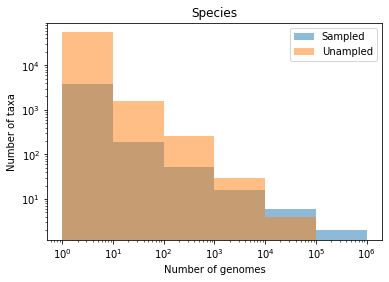

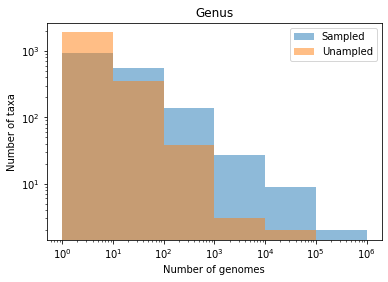

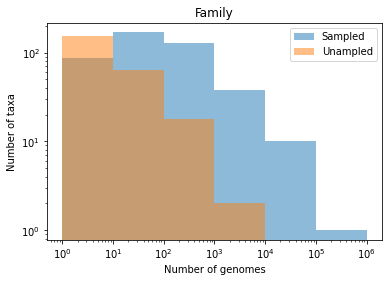

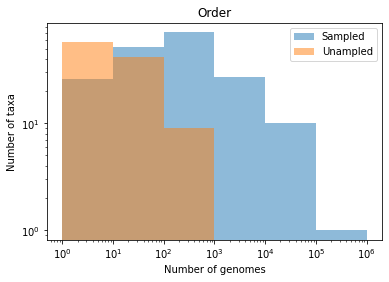

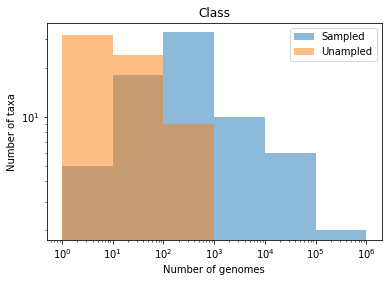

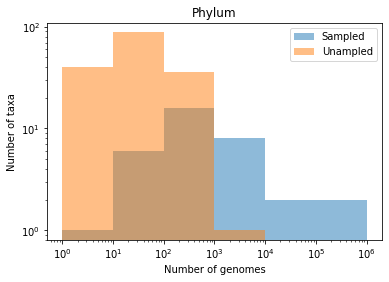

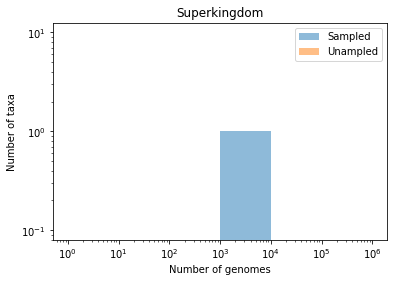

In [38]:
for rank in ranks:
    # Count organisms at rank for NCBI table
    counts = dfa[rank].value_counts().rename('all').to_frame()
    # Count organisms at rank in df table
    counts['sampled'] = counts.index.map(df[rank].value_counts()).fillna(0).astype(int)
    plt.hist(counts.query('sampled != 0')['all'], bins=bins, alpha=0.5, log=True, label='Sampled')
    plt.hist(counts.query('sampled == 0')['all'], bins=bins, alpha=0.5, log=True, label='Unampled')
    plt.xscale('log')
    plt.xlabel('Number of genomes')
    plt.ylabel('Number of taxa')
    plt.legend()
    plt.title(rank.capitalize())
    plt.show()

### Collapse to higher ranks

In [39]:
df.head()

,length,width,volume,surface,shape,species,genus,family,order,class,phylum,superkingdom
taxid,,,,,,,,,,,,
11,2.371708,1.060660,1.783187,7.902917,rod-shaped,Cellulomonas gilvus,Cellulomonas,Cellulomonadaceae,Micrococcales,Actinomycetia,Actinobacteria,Bacteria
14,10.000000,0.489898,1.854174,15.390598,rod-shaped,Dictyoglomus thermophilum,Dictyoglomus,Dictyoglomaceae,Dictyoglomales,Dictyoglomia,Dictyoglomi,Bacteria
23,1.500000,0.700000,0.487470,3.298672,rod-shaped,Shewanella colwelliana,Shewanella,Shewanellaceae,Alteromonadales,Gammaproteobacteria,Proteobacteria,Bacteria
104,1.039230,0.346410,0.087062,1.130973,ring-shaped,Cyclobacterium marinum,Cyclobacterium,Cyclobacteriaceae,Cytophagales,Cytophagia,Bacteroidetes,Bacteria
148,67.082039,0.244949,3.157319,51.621635,NaN,Sediminispirochaeta bajacaliforniensis,Sediminispirochaeta,Spirochaetaceae,Spirochaetales,Spirochaetia,Spirochaetes,Bacteria


Remove duplicates

In [40]:
cols = ['length', 'width', 'volume', 'surface']
df = df.groupby('taxid')[cols].agg(gmean)
df['shape'] = df.index.map(shapes)
df['species'] = df.index.to_series().apply(lambda x: dump[str(x)]['name'])
df = df.loc[sorted(df.index, key = int)]

In [41]:
df.head()

,length,width,volume,surface,shape,species
taxid,,,,,,
11,2.371708,1.060660,1.783187,7.902917,rod-shaped,Cellulomonas gilvus
14,10.000000,0.489898,1.854174,15.390598,rod-shaped,Dictyoglomus thermophilum
23,1.500000,0.700000,0.487470,3.298672,rod-shaped,Shewanella colwelliana
104,1.039230,0.346410,0.087062,1.130973,ring-shaped,Cyclobacterium marinum
114,2.049390,2.049390,4.506844,13.194689,spherical,Gemmata obscuriglobus


In [42]:
df['sptid'] = df.index.astype(str)
#df.drop(columns = ['genus', 'family', 'order', 'class', 'phylum'], inplace = True)
df['id'] = np.arange(df.shape[0])
df.set_index('id', inplace = True)

In [43]:
df.head()

,length,width,volume,surface,shape,species,sptid
id,,,,,,,
0,2.371708,1.060660,1.783187,7.902917,rod-shaped,Cellulomonas gilvus,11
1,10.000000,0.489898,1.854174,15.390598,rod-shaped,Dictyoglomus thermophilum,14
2,1.500000,0.700000,0.487470,3.298672,rod-shaped,Shewanella colwelliana,23
3,1.039230,0.346410,0.087062,1.130973,ring-shaped,Cyclobacterium marinum,104
4,2.049390,2.049390,4.506844,13.194689,spherical,Gemmata obscuriglobus,114


In [44]:
def get_rank(tid, rank):
    if tid == '1':
        return None
    if dump[tid]['rank'] == rank:
        return tid
    return get_rank(dump[tid]['parent'], rank)

In [45]:
cols = ['length', 'width', 'volume', 'surface']

In [46]:
for rank in ranks[1:]:
    #dfr = df.copy().drop(columns=['taxid'])
    dfr = df.copy()
    dfr['taxid'] = dfr['sptid'].apply(lambda x: get_rank(x, rank))
    dfr = dfr.dropna(subset=['taxid'])
    dfr = dfr.groupby('taxid')[cols].agg(gmean)
    dfr = dfr.loc[sorted(dfr.index, key=int)]
    ranks_ = ranks[ranks.index(rank):]
    res = {x: {} for x in ranks_}
    rankset = set(ranks_)
    for tid in dfr.index.astype(str):
        this = tid
        while True:
            rank_ = dump[this]['rank']
            if rank_ in rankset:
                res[rank_][tid] = dump[this]['name']
            parent = dump[this]['parent']
            if this == parent:
                break
            this = parent
    for rank_ in ranks_:
        dfr[rank_] = dfr.index.map(res[rank_])
    #print(dfr.head())
    dfr.to_csv(f'annot/{rank}_all.tsv', sep='\t')
    print(f'{rank}: {dfr.shape[0]}')

genus: 1818
family: 440
order: 187
class: 74
phylum: 35
superkingdom: 2
